# ANALISIS FORECAST - Sesión 05

- Expositor: César Manuel Quezada Balcazar
- Email: cesar.quezada@dmc.pe
- LinkedIn: www.linkedin.com/in/quezada
- Tema: Modelos de Pronostico - Series de Tiempo

In [17]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [18]:
path = '/gdrive/MyDrive/BQ - Data Science/BQ - Repositorios/DMC/Forecast/'

**Importamos los módulos necesarios**

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import requests
import statsmodels.api as sm
import io
import os
import pylab
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import scipy.stats as stats
from scipy.stats import kstest
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

**Leemos nuestra serie de tiempo desde un archvo csv**

In [20]:
df_ventas = pd.read_csv(path + 'DataVentas.csv', sep = ',')
df_ventas.columns = ['fecha','ventas']
df_ventas.head(10)

,fecha,ventas
0,2015-01,2000
1,2015-02,3000
2,2015-03,3000
3,2015-04,3000
4,2015-05,4000
5,2015-06,6000
6,2015-07,7000
7,2015-08,6000
8,2015-09,10000
9,2015-10,12000


In [21]:
# Reaccinamos el index
df_ventas = df_ventas.set_index('fecha')
df_ventas.head(5)

,ventas
fecha,
2015-01,2000
2015-02,3000
2015-03,3000
2015-04,3000
2015-05,4000


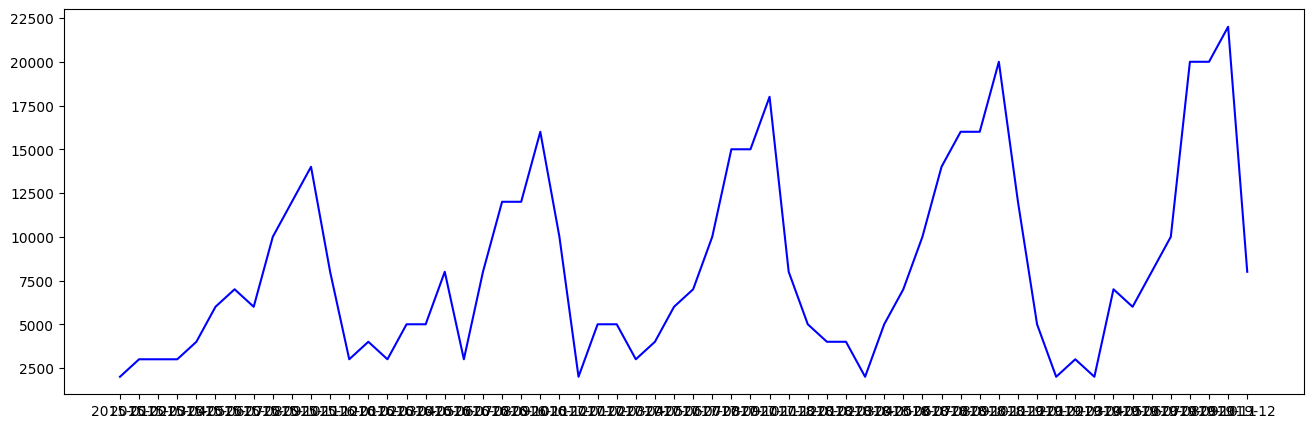

In [22]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df_ventas.ventas, color = 'blue')
plt.show()

In [23]:
# ADF Test
result = adfuller(df_ventas.ventas, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.173524648304151
p-value: 0.6848798142711484


In [24]:
# KPSS Test
result = kpss(df_ventas.ventas, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])


KPSS Statistic: 0.308781
p-value: 0.100000


<ipython-input-24-19a5ab581bc7>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(df_ventas.ventas, regression='c')


Diferenciando y aplicando logaritmo

**ACF Y PACF**

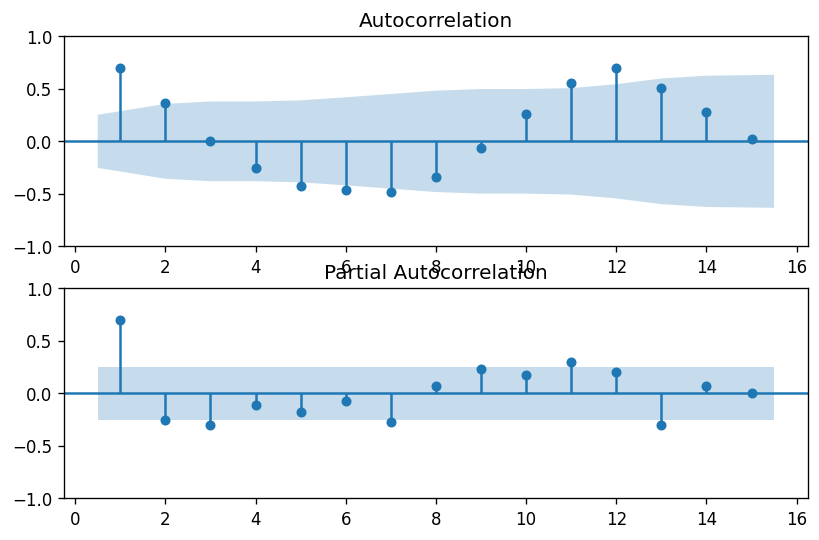

In [25]:
# Create figure
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,5))

plot_acf(df_ventas, lags = 15, zero = False, ax = ax1) #Make ACF plot
plot_pacf(df_ventas, lags = 15, zero = False, ax = ax2) #Make PACF plot
plt.show()

**(1) Particion la serie training/testing**

In [36]:
df_ventas.head()

,ventas
fecha,
2015-01,2000
2015-02,3000
2015-03,3000
2015-04,3000
2015-05,4000


In [28]:
tss = TimeSeriesSplit(n_splits = 4)

In [30]:
X = df_ventas.drop(labels=['ventas'], axis=1)
y = df_ventas['ventas']

In [31]:
df_ventas.shape

(60, 1)

In [32]:
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [33]:
X_train.shape, y_train.shape

((48, 0), (48,))

In [34]:
X_test.shape, y_test.shape

((12, 0), (12,))

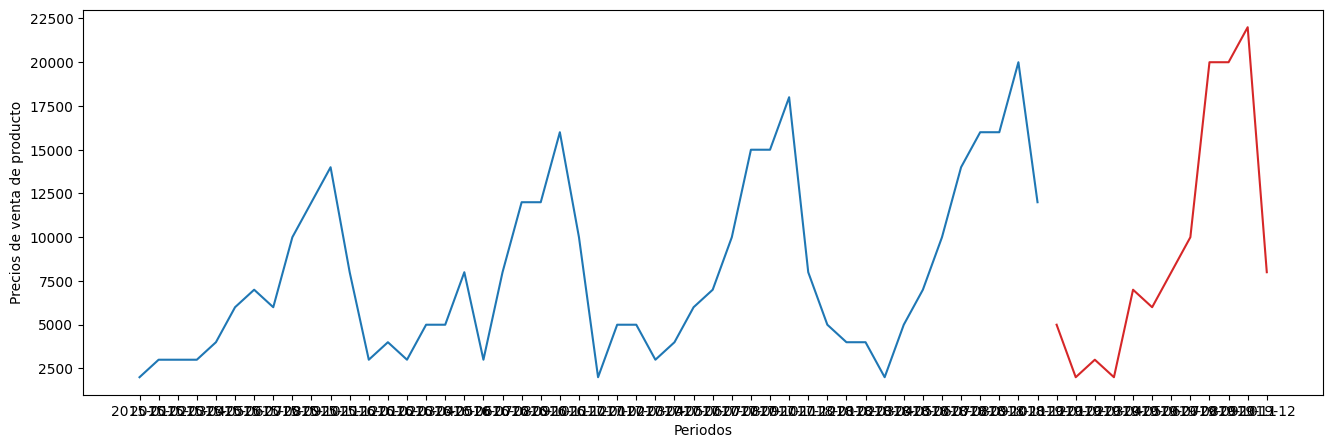

In [35]:
# Graficamos los periodos train y test
plt.figure(figsize=(16,5), dpi=100)
plt.plot(pd.DataFrame(y_train).index, pd.DataFrame(y_train).ventas,color='tab:blue')
plt.plot(pd.DataFrame(y_test).index, pd.DataFrame(y_test).ventas,color='tab:red')
plt.xlabel('Periodos')
plt.ylabel('Precios de venta de producto')
plt.show()

In [ ]:
y_test

fecha
2019-01     5000
2019-02     2000
2019-03     3000
2019-04     2000
2019-05     7000
2019-06     6000
2019-07     8000
2019-08    10000
2019-09    20000
2019-10    20000
2019-11    22000
2019-12     8000
Name: ventas, dtype: int64

## **(1) Proceso AR**

In [ ]:
model_ar1 = SARIMAX(y_train, order = (1,0,0))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
results_ar1 = model_ar1.fit()

In [ ]:
print(results_ar1.summary())

                               SARIMAX Results                                
Dep. Variable:                 ventas   No. Observations:                   48
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -460.348
Date:                Mon, 06 Nov 2023   AIC                            924.695
Time:                        19:55:33   BIC                            928.438
Sample:                    01-01-2015   HQIC                           926.110
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9250      0.040     23.221      0.000       0.847       1.003
sigma2      1.224e+07   2.48e-10   4.93e+16      0.000    1.22e+07    1.22e+07
Ljung-Box (L1) (Q):                   0.06   Jarque-

In [ ]:
# Predecimos valores futuros
forecast_ar1 = results_ar1.get_forecast(steps = 12).predicted_mean.rename('forecast ar1')
forecast_ar1

2019-01-01    11099.795474
2019-02-01    10267.121630
2019-03-01     9496.912517
2019-04-01     8784.482214
2019-05-01     8125.496327
2019-06-01     7515.945613
2019-07-01     6952.121591
2019-08-01     6430.593981
2019-09-01     5948.189830
2019-10-01     5501.974213
2019-11-01     5089.232372
2019-12-01     4707.453204
Freq: MS, Name: forecast ar1, dtype: float64

In [ ]:
# reasignamos index
y_test.index = forecast_ar1.index
y_test

2019-01-01     5000
2019-02-01     2000
2019-03-01     3000
2019-04-01     2000
2019-05-01     7000
2019-06-01     6000
2019-07-01     8000
2019-08-01    10000
2019-09-01    20000
2019-10-01    20000
2019-11-01    22000
2019-12-01     8000
Freq: MS, Name: ventas, dtype: int64

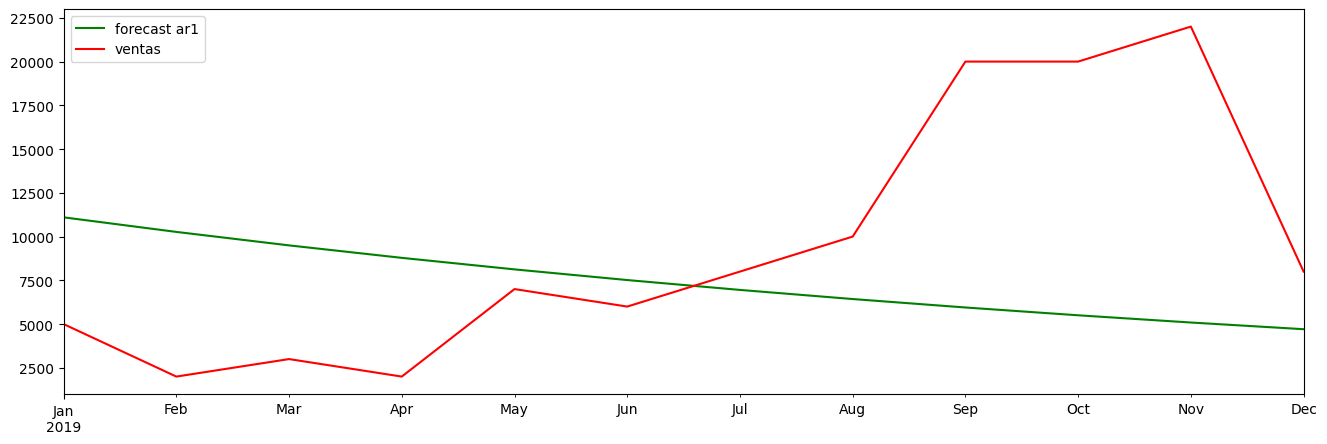

In [ ]:
# plot
plt.figure(figsize=(16,5), dpi=100)
forecast_ar1.plot(color = 'green', legend = True)
y_test.plot(color='red',legend = True)
plt.show()

In [ ]:
#Calculamos el ECM
error = mean_squared_error(y_test, forecast_ar1)
print('Test MSE: %.4f' % error)

Test MSE: 76304705.3768


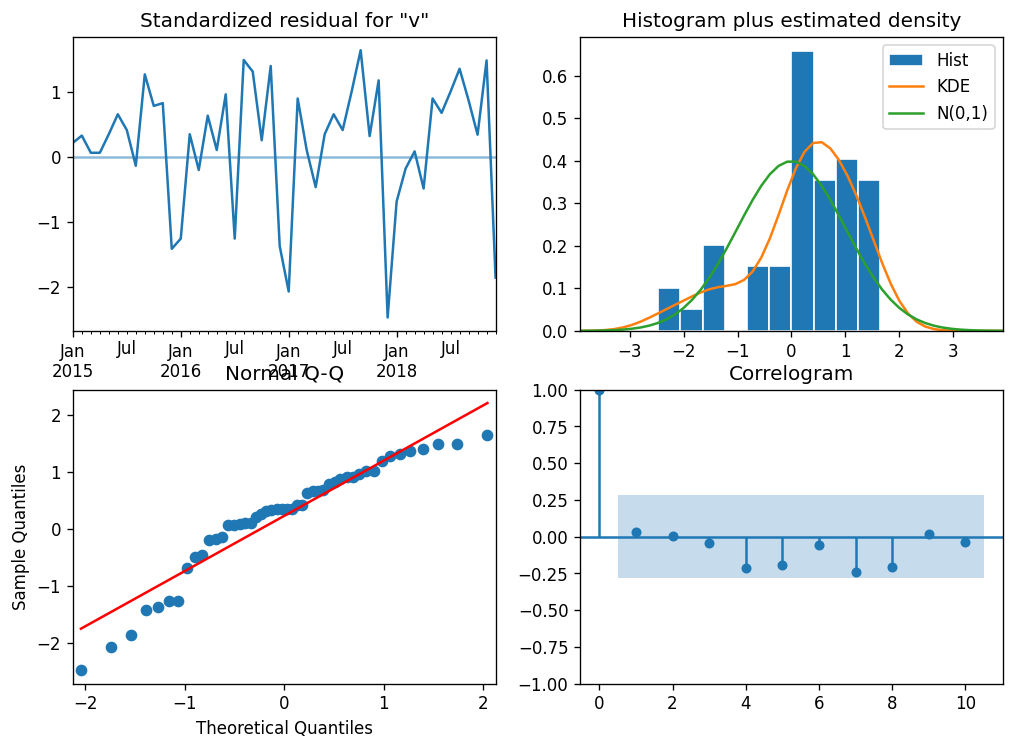

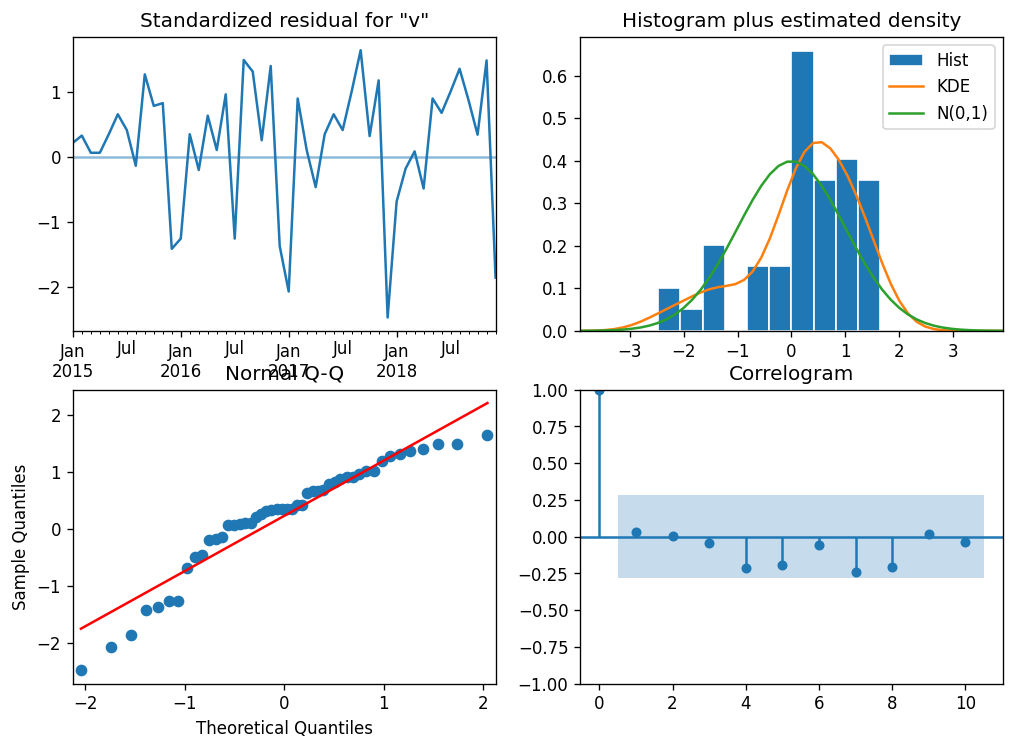

In [ ]:
# Plot residuals
results_ar1.plot_diagnostics()

## **(2) Proceso MA**

In [ ]:
# model_ma1 = SARIMAX(y_train, order = (0,0,2), transformed = True,
#                     enforce_stationarity=False,
#                       enforce_invertibility=False)
model_ma1 = SARIMAX(y_train, order = (0,0,2), trend = 'c')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
results_ma1 = model_ma1.fit()

In [ ]:
# Predecimos valores futuros
forecast_ma1 = results_ma1.get_forecast(steps = 12).predicted_mean.rename('forecast ma1')

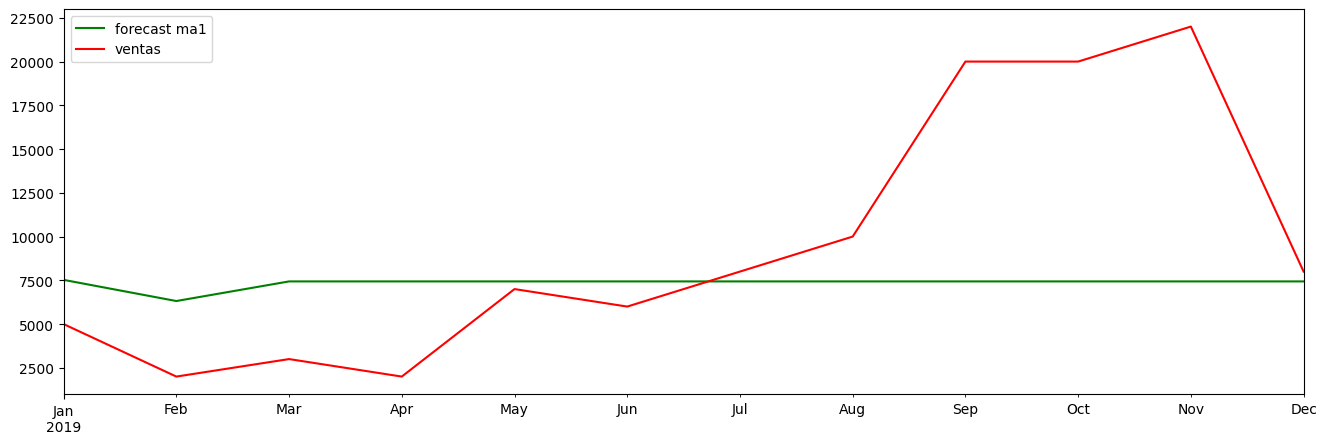

In [ ]:
# plot
plt.figure(figsize=(16,5), dpi=100)
forecast_ma1.plot(color = 'green', legend = True)
y_test.plot(color='red',legend = True)
plt.show()

**(3) Proceso ARIMA**

In [ ]:
model_arima1 = SARIMAX(y_train, order = (1,0,2),
                       enforce_stationarity=False,
                      enforce_invertibility=False) # Just a AR(p) model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
results_arima1 = model_arima1.fit()

In [ ]:
print(results_arima1.summary())

                               SARIMAX Results                                
Dep. Variable:                 ventas   No. Observations:                   48
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -431.872
Date:                Mon, 06 Nov 2023   AIC                            871.744
Time:                        20:01:06   BIC                            878.970
Sample:                    01-01-2015   HQIC                           874.438
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9147      0.072     12.774      0.000       0.774       1.055
ma.L1          0.0925      0.196      0.471      0.638      -0.293       0.478
ma.L2          0.0890      0.259      0.343      0.7

In [ ]:
# Predecimos valores futuros
forecast_arima1 = results_arima1.get_forecast(steps = 12).predicted_mean.rename('forecast ma1')
forecast_arima1

2019-01-01    10796.476078
2019-02-01     9267.710989
2019-03-01     8477.287386
2019-04-01     7754.277351
2019-05-01     7092.931324
2019-06-01     6487.990110
2019-07-01     5934.643062
2019-08-01     5428.489821
2019-09-01     4965.505326
2019-10-01     4542.007807
2019-11-01     4154.629502
2019-12-01     3800.289878
Freq: MS, Name: forecast ma1, dtype: float64

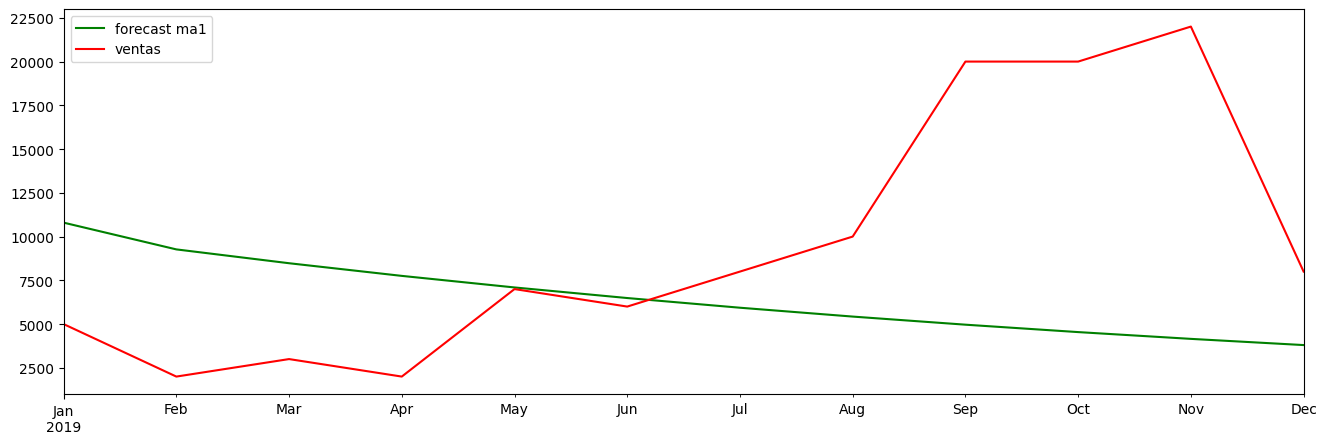

In [ ]:
# plot
plt.figure(figsize=(16,5), dpi=100)
forecast_arima1.plot(color = 'green', legend = True)
y_test.plot(color='red',legend = True)
plt.show()

In [ ]:
#Calculamos el ECM
error = mean_squared_error(y_test, forecast_arima1)
print('Test MSE: %.4f' % error)

Test MSE: 81335223.6755


## **(4) Proceso SARIMA**

In [ ]:
model_sarima = SARIMAX(y_train, order= (1,1,2), seasonal_order=(0,1,0,12),
                       enforce_stationarity=False,
                      enforce_invertibility=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
results_sarima = model_sarima.fit()

In [ ]:
# Predecimos valores futuros
forecast_sarima = results_sarima.get_forecast(steps = 12).predicted_mean.rename('forecast sarima')

In [ ]:
#Calculamos el ECM
error = mean_squared_error(y_test, forecast_sarima)
print('Test MSE: %.4f' % error)

Test MSE: 12774785.2271


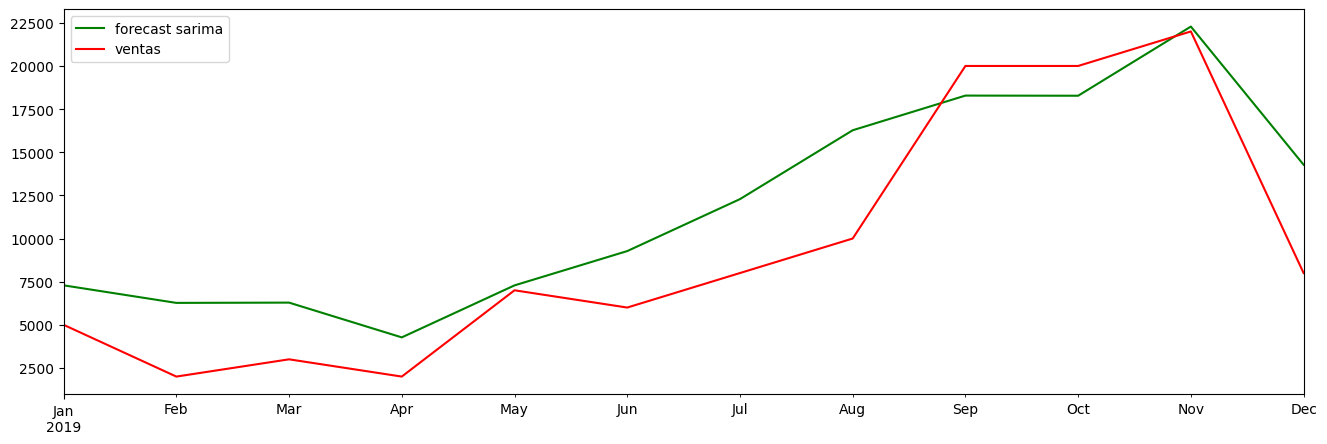

In [ ]:
# plot
plt.figure(figsize=(16,5), dpi=100)
forecast_sarima.plot(color = 'green', legend = True)
y_test.plot(color='red',legend = True)
plt.show()

**Forecast final**

In [ ]:
# Generación de Modelos
# ---------------------
# SARIMA
model_sarima_f1 = SARIMAX(df_ventas.ventas, order= (1,0,2), seasonal_order=(0,1,0,12),
                       enforce_stationarity=False,
                      enforce_invertibility=False)

# SARIMA
model_sarima_f2 = SARIMAX(df_ventas.ventas, order= (1,1,2), seasonal_order=(0,1,0,12),
                       enforce_stationarity=False,
                      enforce_invertibility=False)

# SARIMA
model_sarima_f3 = SARIMAX(df_ventas.ventas, order= (2,1,2), seasonal_order=(0,1,0,12),
                       enforce_stationarity=False,
                      enforce_invertibility=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

In [ ]:
# Ajuste de modelos
# -----------------
results_sarima_f1 = model_sarima_f1.fit()
results_sarima_f2 = model_sarima_f2.fit()
results_sarima_f3 = model_sarima_f3.fit()

In [ ]:
# Predicción
predict_sarima_f1 = results_sarima_f1.get_prediction(start = -12).predicted_mean.rename('forecast sarima1')
predict_sarima_f2 = results_sarima_f2.get_prediction(start = -12).predicted_mean.rename('forecast sarima2')
predict_sarima_f3 = results_sarima_f3.get_prediction(start = -12).predicted_mean.rename('forecast sarima2')

In [ ]:
predict_sarima_f2

2019-01-01     7111.426789
2019-02-01     5127.474656
2019-03-01     4517.236820
2019-04-01     2523.920755
2019-05-01     5588.087396
2019-06-01     8077.465837
2019-07-01    10262.729917
2019-08-01    13900.676963
2019-09-01    15082.501974
2019-10-01    17089.773942
2019-11-01    21228.585965
2019-12-01    13036.294449
Freq: MS, Name: forecast sarima2, dtype: float64

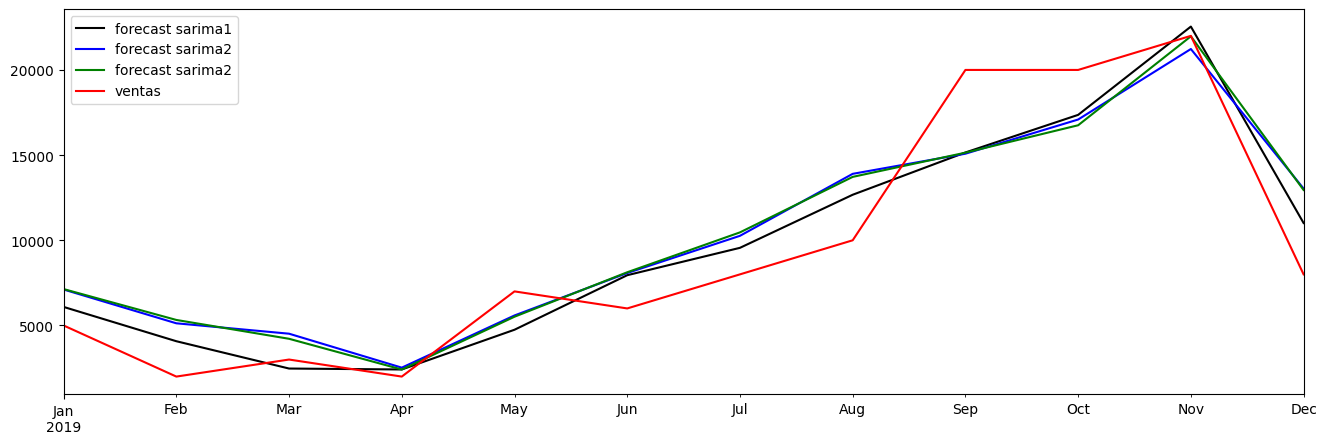

In [ ]:
# plot multiple
plt.figure(figsize=(16,5), dpi=100)
predict_sarima_f1.plot(color = 'black', legend = True)
predict_sarima_f2.plot(color = 'blue', legend = True)
predict_sarima_f3.plot(color = 'green', legend = True)
y_test.plot(color = 'red',legend = True)
plt.show()

In [ ]:
# forecast
forecast_sarima_f1 = results_sarima_f1.get_forecast(steps = 12).predicted_mean.rename('forecast sarima1')
forecast_sarima_f2 = results_sarima_f2.get_forecast(steps = 12).predicted_mean.rename('forecast sarima2')
forecast_sarima_f3 = results_sarima_f3.get_forecast(steps = 12).predicted_mean.rename('forecast sarima3')

In [ ]:
forecast_sarima_f3

2020-01-01     4747.382838
2020-02-01     1630.142307
2020-03-01     3509.347388
2020-04-01     1962.763025
2020-05-01     7476.785015
2020-06-01     6053.937556
2020-07-01     8415.694838
2020-08-01    10109.856022
2020-09-01    20369.342838
2020-10-01    20149.418923
2020-11-01    22335.871999
2020-12-01     8177.811054
Freq: MS, Name: forecast sarima3, dtype: float64

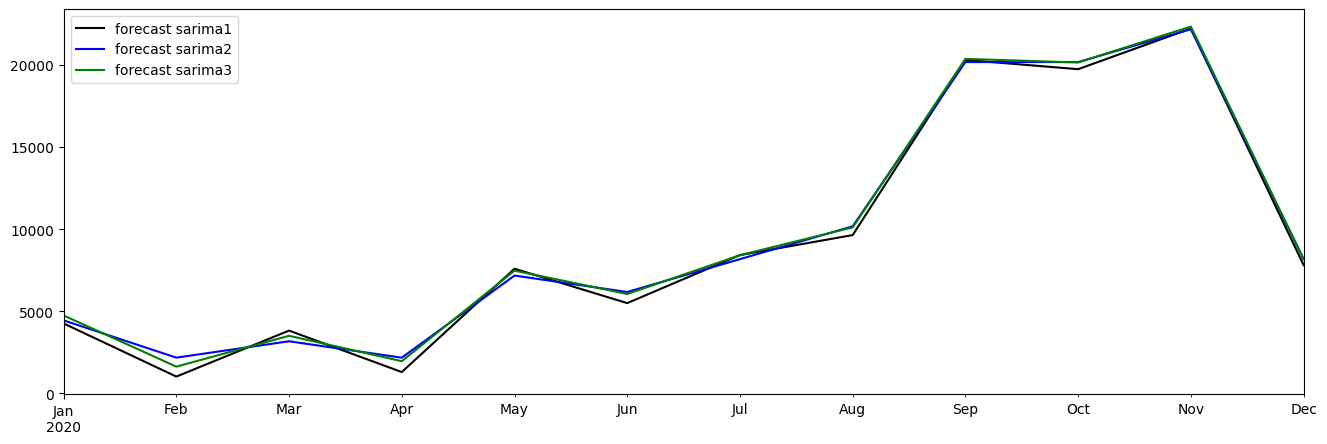

In [ ]:
# plot multiple
plt.figure(figsize=(16,5), dpi=100)
forecast_sarima_f1.plot(color = 'black', legend = True)
forecast_sarima_f2.plot(color = 'blue', legend = True)
forecast_sarima_f3.plot(color = 'green', legend = True)
plt.show()